In [15]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import seaborn as sns
from calendar import month_name
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#import warnings
#warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, auc
from pdpbox import pdp, info_plots
import graphviz

In [16]:
class Report:
    def __init__(self, X_test, y_test):
        self.X = X_test
        self.y = y_test
    
    def metrics(self, model):
        y_pred = model.predict(self.X)
        
        print('Accuracy score:\n')
        print(accuracy_score(self.y, y_pred))
        
        print('\nConfusion Matrix:\n')
        print(confusion_matrix(self.y, y_pred))
        
        print('\nClassification Report:\n')
        print(classification_report(self.y, y_pred))
    
    def plot_roc_curve(self, model, part='h1', save=False):
        probs = model.predict_proba(self.X)
        preds = probs[:, 1]

        fpr, tpr, threshold = roc_curve(self.y, preds)
        roc_auc = auc(fpr, tpr)

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        
        if save:
            name = model.__class__.__name__
            plt.savefig(f'{name}_{part}.png')
        plt.show()

In [17]:
hotel3 = pd.read_csv('data/hotel3.csv', index_col=0)
pd.set_option('display.max_columns', None)

In [135]:
#hotel3.info()

### Model All features

In [5]:
# split data
X, y = hotel3.iloc[:,1:], hotel3.iloc[:,0]
total_data = len(X.index)
split = round(total_data*0.8)
X_train = X.iloc[:split, :]
X_test = X.iloc[split:, :]
y_train = y.iloc[:split]
y_test = y.iloc[split:]

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [7]:
imputer = KNNImputer()
imputer.fit(X_train)
X_train = imputer.transform(X_train)

In [8]:
print('missing: %d' % sum(np.isnan(X_train).flatten()))

missing: 0


In [65]:
feature_names = X.columns.tolist()
features = pd.Series(feature_names)

In [9]:
clf_all = XGBClassifier(max_depth=15, 
                    learning_rate=0.1, 
                    n_estimators=100, 
                    min_child_weight=1, 
                    subsample=0.5, 
                    colsample_bytree=0.6, 
                    scale_pos_weight=1.7,
                    eval_metric= ['auc','error'], 
                    early_stopping_rounds=5, 
                    random_state=42)
clf_all.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.6, early_stopping_rounds=5,
              eval_metric=['auc', 'error'], max_depth=15, random_state=42,
              scale_pos_weight=1.7, subsample=0.5)

In [77]:
clf_all.get_num_boosting_rounds()

100

In [68]:
X_test = scaler.transform(X_test)
X_test = imputer.transform(X_test)

In [78]:
#Predict training set:
y_tpreds = clf_all.predict(X_train)
y_tprob = clf_all.predict_proba(X_train)[:,1]

y_ttpreds = clf_all.predict(X_test)
y_ttprob = clf_all.predict_proba(X_test)[:,1]


In [79]:
print(classification_report(y_test,y_ttpreds,target_names=['not_canceled', 'canceled']))

              precision    recall  f1-score   support

not_canceled       0.88      0.97      0.92     15525
    canceled       0.94      0.75      0.83      8348

    accuracy                           0.89     23873
   macro avg       0.91      0.86      0.88     23873
weighted avg       0.90      0.89      0.89     23873



In [80]:
roc_auc_score(y_test, y_ttpreds)

0.8611694393712477

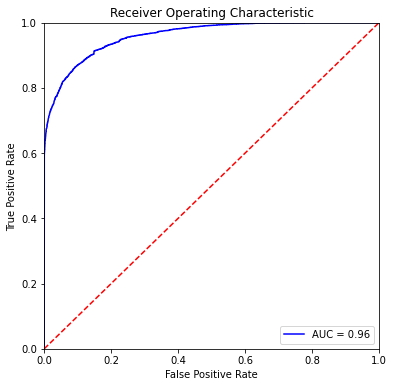

In [81]:
report = Report(X_test, y_test)
report.plot_roc_curve(clf_all, save=True)

In [96]:
importances = clf_all.feature_importances_*100
feature_importances = pd.Series(importances, index=features)
top_important = feature_importances.sort_values(ascending=False)[:5]
#top_important

In [115]:
y = top_important.tolist()
y = [round(i, 2) for i in y]
y = sorted(y, reverse=False)


0 1.82
1 2.12
2 8.34
3 22.72
4 51.11


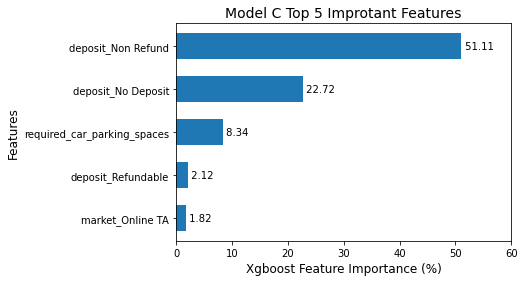

In [130]:

sorted_idx = clf_all.feature_importances_.argsort()[-5:]
plt.barh(features[sorted_idx], importances[sorted_idx], height=0.6)
plt.xlabel("Xgboost Feature Importance (%)", size=12)
plt.title('Model C Top 5 Improtant Features',size=14)
plt.xlim((0, 60))
plt.ylabel('Features', size=12)
for i, v in enumerate(y):
    print(i, v)
    plt.text(v, i, " "+str(v), color='black', va='center')
plt.savefig('Top 5 Feature Importance')

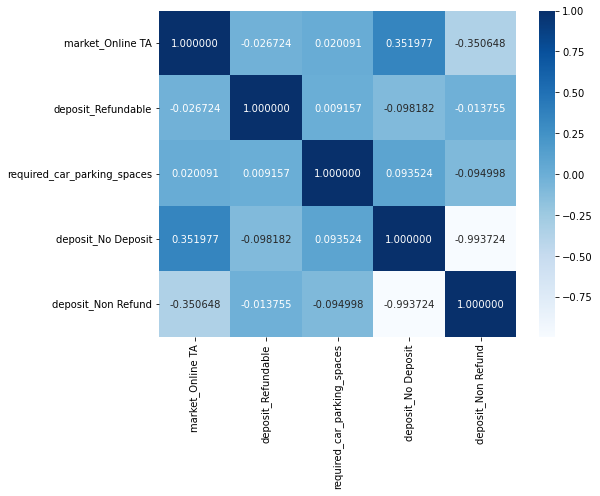

In [133]:
top_features = hotel3[features[sorted_idx].tolist()]
corr = top_features.corr()
corr = sns.heatmap(corr, 
                   xticklabels=corr.columns,
                   yticklabels=corr.columns,
                   annot=True, fmt="f",cmap="Blues")

coeficient correlation analysis shows that there are no two features highly correlated with each other. Then, we can do partial dependency analysis for no correlated variables.

In [85]:
# for pdpbox feature analysis only
clf_pdp = XGBClassifier(max_depth=15, 
                    learning_rate=0.1, 
                    n_estimators=100, 
                    min_child_weight=1, 
                    subsample=0.5, 
                    colsample_bytree=0.6, 
                    scale_pos_weight=1.7,
                    eval_metric= ['auc','error'], 
                    early_stopping_rounds=5, 
                    random_state=42)


In [86]:
# train model with df, for pdpbox
pdp_Xtrain= pd.DataFrame(X.iloc[:split, :], columns=feature_names)
pdp_model = clf_pdp.fit(pdp_Xtrain, y_train)

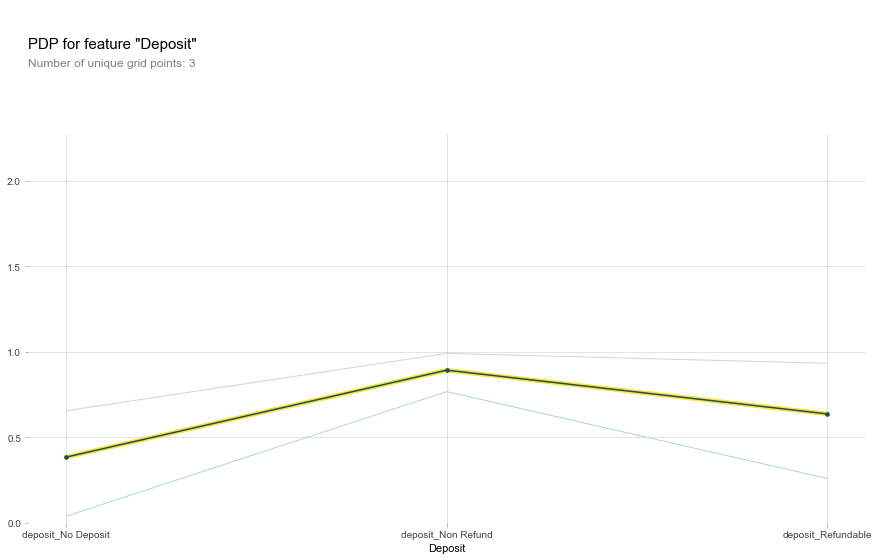

In [47]:
pdp_deposit= pdp.pdp_isolate(model=pdp_model, dataset=pdp_Xtrain, model_features=pdp_Xtrain.columns, feature=['deposit_No Deposit','deposit_Non Refund','deposit_Refundable'])

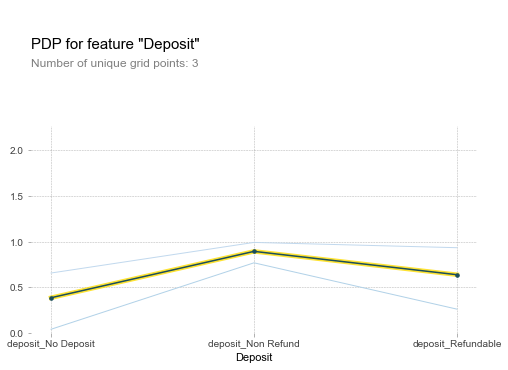

In [144]:
plot_params = { }
fig, axes = pdp.pdp_plot(pdp_deposit, 'Deposit', center=False, cluster=True,n_cluster_centers=2, plot_lines=True, figsize=(8,6), plot_params)

varies between 0.4 to 0.65. 

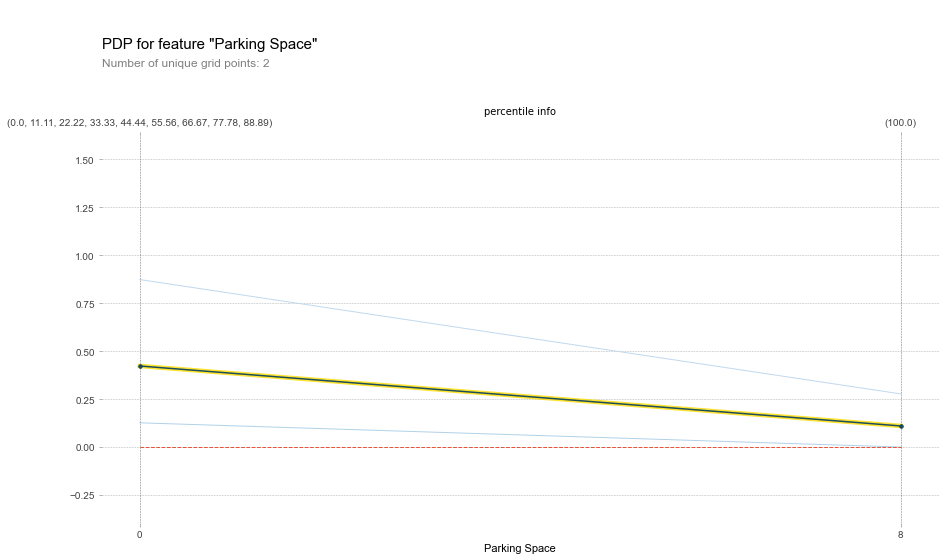

In [48]:
pdp_parking= pdp.pdp_isolate(model=pdp_model, dataset=pdp_Xtrain, model_features=pdp_Xtrain.columns, feature='required_car_parking_spaces')


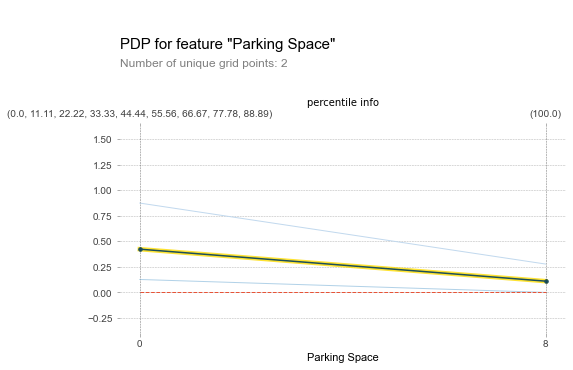

In [148]:
fig, axes = pdp.pdp_plot(pdp_parking, 'Parking Space', center=False, cluster=True,n_cluster_centers=2, plot_lines=True, x_quantile=True, show_percentile=True, figsize=(8,6))

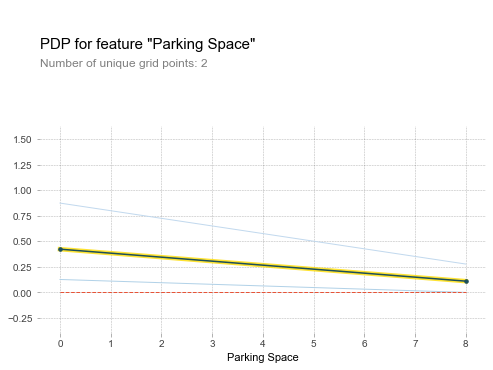

In [146]:
fig, axes = pdp.pdp_plot(pdp_parking, 'Parking Space', center=False, cluster=True,n_cluster_centers=2, plot_lines=True, figsize=(8,6))

varies between 0.4 to 0.15, the relationship is negative. as the number of required parking space increase, the probability of classify an observation to canceld is low. 

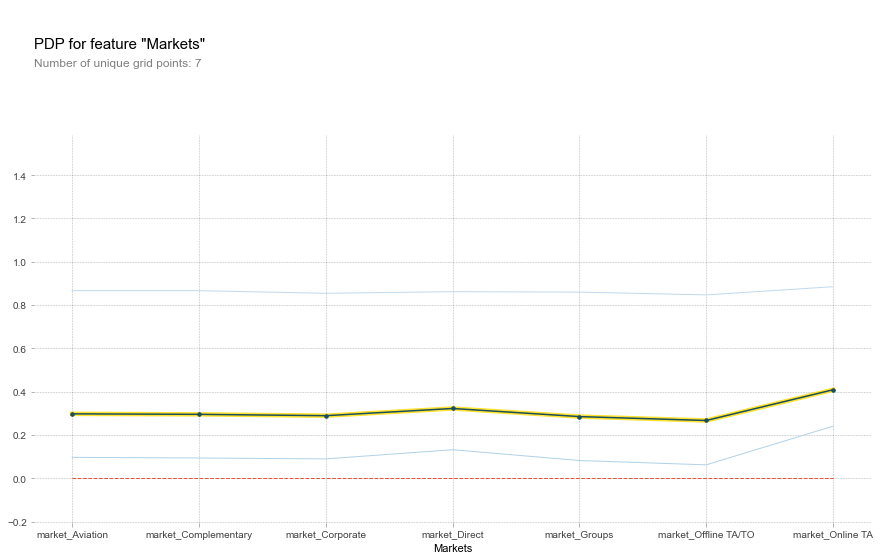

In [49]:
markets = ['market_Aviation', 'market_Complementary', 'market_Corporate', 'market_Direct', 'market_Groups', 'market_Offline TA/TO', 'market_Online TA']
pdp_markets= pdp.pdp_isolate(model=pdp_model, dataset=pdp_Xtrain, model_features=pdp_Xtrain.columns, feature=markets)


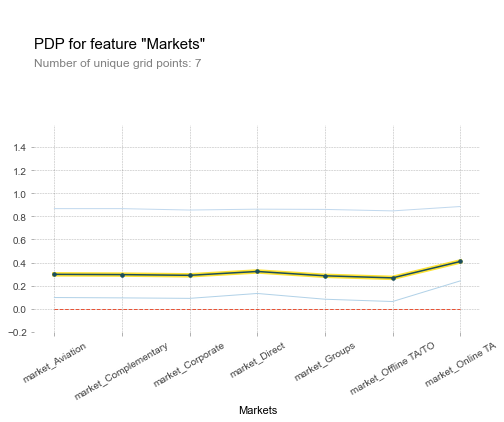

In [149]:
fig, axes = pdp.pdp_plot(pdp_markets, 'Markets', center=False, cluster=True,n_cluster_centers=2, plot_lines=True, figsize=(8,6), plot_params={'xticks_rotation': 30})

### Model 2 distance

In [18]:
dist = hotel3[['is_canceled', 'lead_time', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adults', 'children', 'babies', 'total_num_people', 'adr', 'market_Complementary', 'deposit_No Deposit', 'deposit_Non Refund', 'deposit_Refundable']]

In [19]:
# split data
Xd, yd = dist.iloc[:,1:], dist.iloc[:,0]
total_datad = len(Xd.index)
split = round(total_datad*0.8)
Xd_train = Xd.iloc[:split, :]
Xd_test = Xd.iloc[split:, :]
yd_train = yd.iloc[:split]
yd_test = yd.iloc[split:]

In [20]:
scaler = StandardScaler()
scaler.fit(Xd_train)
Xd_train = scaler.transform(Xd_train)
imputer = KNNImputer()
imputer.fit(Xd_train)
Xd_train = imputer.transform(Xd_train)

In [21]:
print('missing: %d' % sum(np.isnan(Xd_train).flatten()))

missing: 0


In [22]:
# [0.1, 25.0, 0.0, 0.4, 0.9]
clf_dist = XGBClassifier(max_depth=25, 
                         learning_rate=0.1, 
                         n_estimators=300, 
                         min_child_weight=0, 
                         subsample=0.4, 
                         colsample_bytree=0.9, 
                         scale_pos_weight=1.7,
                         eval_metric= ['auc','error'], 
                         early_stopping_rounds=5,
                         random_state=42)
clf_dist.fit(Xd_train, yd_train)

XGBClassifier(colsample_bytree=0.9, early_stopping_rounds=5,
              eval_metric=['auc', 'error'], max_depth=25, min_child_weight=0,
              n_estimators=300, random_state=42, scale_pos_weight=1.7,
              subsample=0.4)

In [34]:
clf_plot = XGBClassifier(max_depth=2, 
                         learning_rate=0.1, 
                         n_estimators=1, 
                         min_child_weight=0, 
                         subsample=0.4, 
                         colsample_bytree=0.9, 
                         scale_pos_weight=1.7,
                         eval_metric= ['auc','error'], 
                         early_stopping_rounds=5,
                         random_state=42)
clf_plot.fit(Xd_train, yd_train)

XGBClassifier(colsample_bytree=0.9, early_stopping_rounds=5,
              eval_metric=['auc', 'error'], max_depth=2, min_child_weight=0,
              n_estimators=1, random_state=42, scale_pos_weight=1.7,
              subsample=0.4)

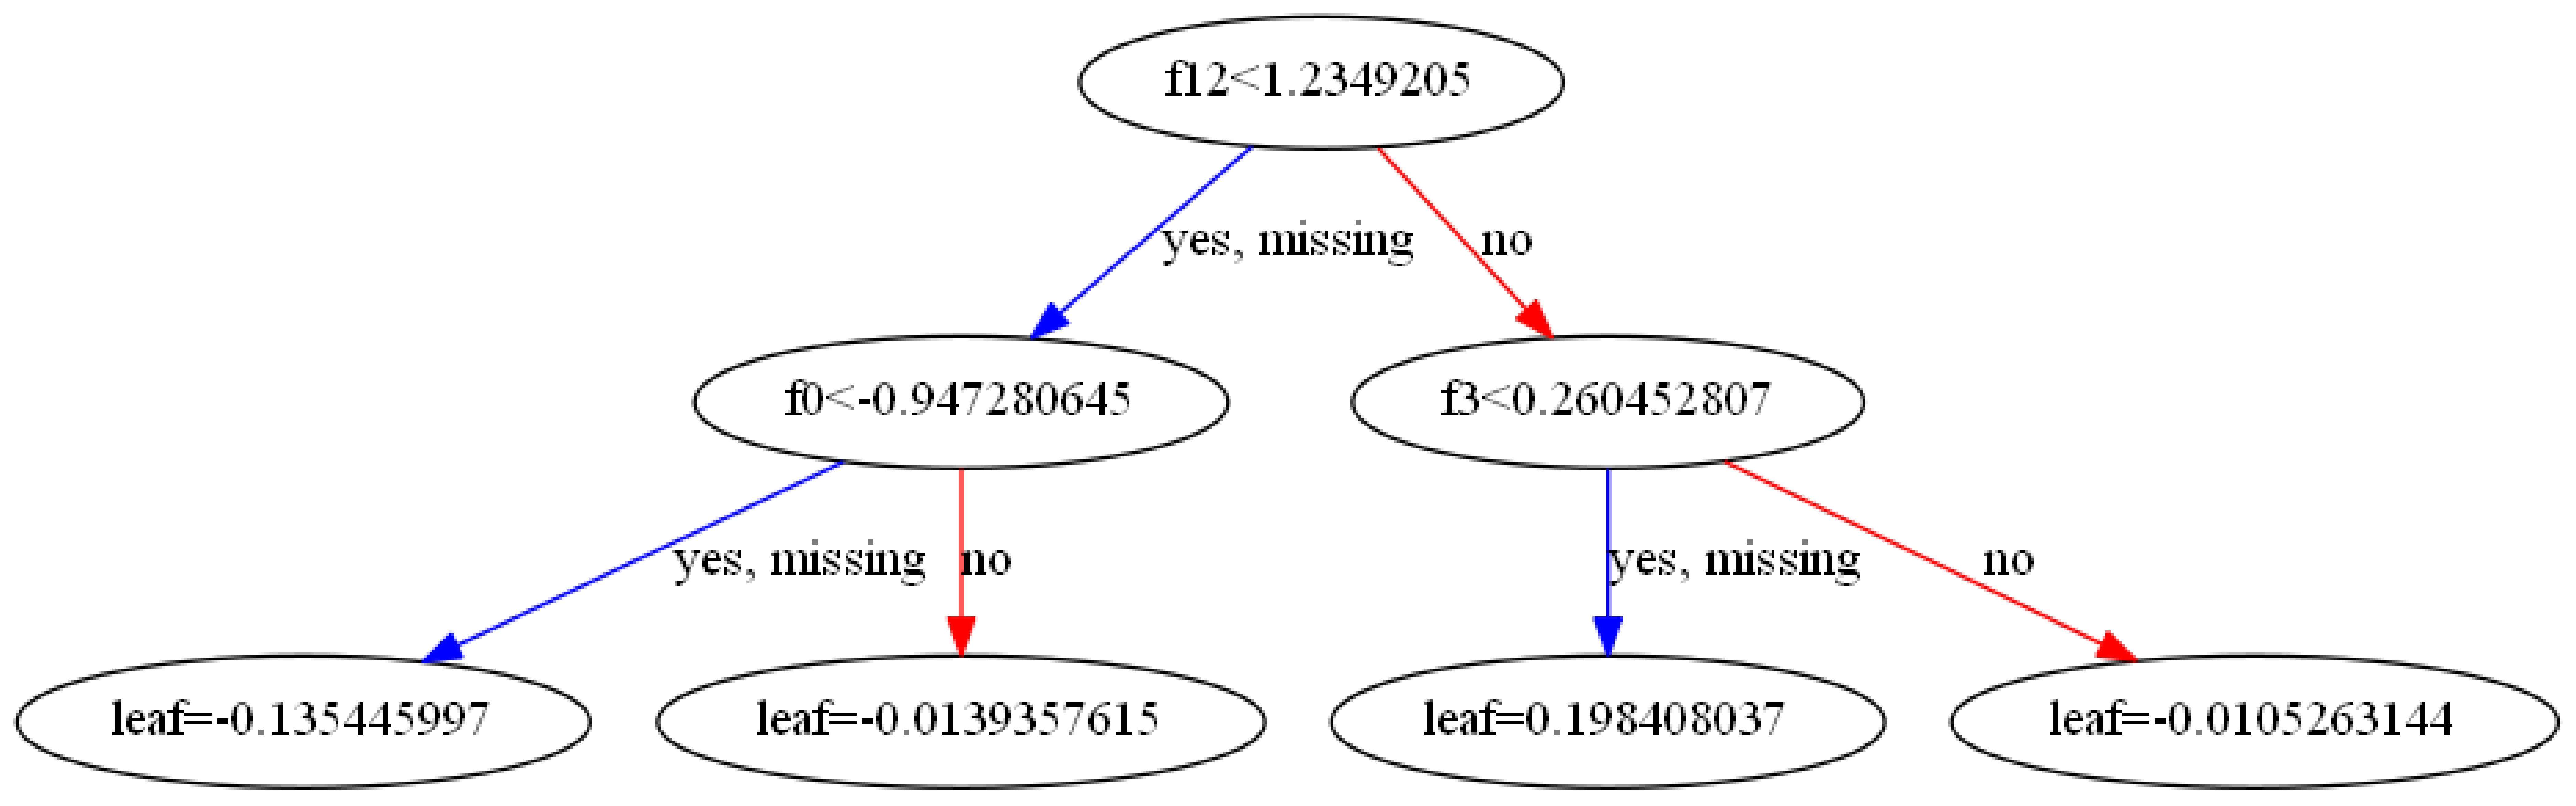

In [35]:
xgb.plot_tree(clf_plot)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('treeH2.png')

In [217]:
clf_dist.get_num_boosting_rounds()

300

In [194]:
Xd_test = scaler.transform(Xd_test)
Xd_test = imputer.transform(Xd_test)

In [218]:
#Predict training set:
yd_tpreds = clf_dist.predict(Xd_train)
yd_tprob = clf_dist.predict_proba(Xd_train)[:,1]

yd_ttpreds = clf_dist.predict(Xd_test)
yd_ttprob = clf_dist.predict_proba(Xd_test)[:,1]

In [219]:
# ntree=300
print(classification_report(yd_train,yd_tpreds,target_names=['not_canceled', 'canceled']))
print(classification_report(yd_test,yd_ttpreds,target_names=['not_canceled', 'canceled']))

              precision    recall  f1-score   support

not_canceled       0.96      0.94      0.95     59625
    canceled       0.90      0.94      0.92     35866

    accuracy                           0.94     95491
   macro avg       0.93      0.94      0.94     95491
weighted avg       0.94      0.94      0.94     95491

              precision    recall  f1-score   support

not_canceled       0.82      0.94      0.88     15525
    canceled       0.85      0.62      0.72      8348

    accuracy                           0.83     23873
   macro avg       0.84      0.78      0.80     23873
weighted avg       0.83      0.83      0.82     23873



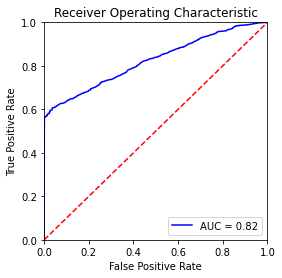

In [266]:
report_dist = Report(Xd_test, yd_test)
report_dist.plot_roc_curve(clf_dist, save=True)

### Model 3 non-distance

In [234]:
no_dist = hotel3.drop(columns = ['lead_time', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adults', 'children', 'babies', 'total_num_people', 'adr', 'market_Complementary', 'deposit_No Deposit', 'deposit_Non Refund', 'deposit_Refundable'])

In [236]:
# split data
Xn, yn = no_dist.iloc[:,1:], no_dist.iloc[:,0]
total_datan = len(Xn.index)
split = round(total_datan*0.8)
Xn_train = Xn.iloc[:split, :]
Xn_test = Xn.iloc[split:, :]
yn_train = yn.iloc[:split]
yn_test = yn.iloc[split:]

In [237]:
scaler = StandardScaler()
scaler.fit(Xn_train)
Xn_train = scaler.transform(Xn_train)
imputer = KNNImputer()
imputer.fit(Xn_train)
Xn_train = imputer.transform(Xn_train)

In [238]:
print('missing: %d' % sum(np.isnan(Xn_train).flatten()))

missing: 0


In [259]:
# [0.001, 25.0, 0.0, 0.6, 0.7]
clf_NoDist = XGBClassifier(max_depth=25, 
                           learning_rate=0.001, 
                           n_estimators=300, 
                           min_child_weight=0, 
                           subsample=0.6, 
                           colsample_bytree=0.7, 
                           scale_pos_weight=1.7,
                           eval_metric= ['auc','error'],
                           early_stopping_rounds=5, 
                           random_state=42)
clf_NoDist.fit(Xn_train, yn_train)

XGBClassifier(colsample_bytree=0.7, early_stopping_rounds=5,
              eval_metric=['auc', 'error'], learning_rate=0.001, max_depth=25,
              min_child_weight=0, n_estimators=300, random_state=42,
              scale_pos_weight=1.7, subsample=0.6)

In [260]:
clf_NoDist.get_num_boosting_rounds()

300

In [241]:
Xn_test = scaler.transform(Xn_test)
Xn_test = imputer.transform(Xn_test)

In [261]:
#Predict training set:
yn_tpreds = clf_NoDist.predict(Xn_train)
yn_tprob = clf_NoDist.predict_proba(Xn_train)[:,1]

yn_ttpreds = clf_NoDist.predict(Xn_test)
yn_ttprob = clf_NoDist.predict_proba(Xn_test)[:,1]

In [262]:
print(classification_report(yn_train,yn_tpreds,target_names=['not_canceled', 'canceled']))
print(classification_report(yn_test,yn_ttpreds,target_names=['not_canceled', 'canceled']))

              precision    recall  f1-score   support

not_canceled       0.96      0.92      0.94     59625
    canceled       0.88      0.94      0.91     35866

    accuracy                           0.93     95491
   macro avg       0.92      0.93      0.92     95491
weighted avg       0.93      0.93      0.93     95491

              precision    recall  f1-score   support

not_canceled       0.80      0.95      0.87     15525
    canceled       0.86      0.56      0.68      8348

    accuracy                           0.81     23873
   macro avg       0.83      0.76      0.77     23873
weighted avg       0.82      0.81      0.80     23873



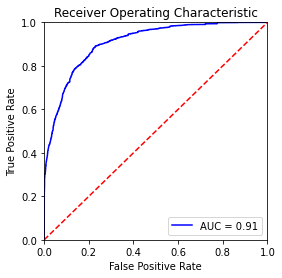

In [265]:
report_NoDist = Report(Xn_test, yn_test)
report_NoDist.plot_roc_curve(clf_NoDist, save=True)